# **Paso 1. Aplicaci√≥n de los modelos**

### **1. Descarga de YahooFinancelas series de precios de cierre de RYLD, TSLA, TM y GM en las fechas: 22-04-2019 al 31-12-2022**

In [31]:
#Otros de manipulaci√≥n de datos
library(forecast)
library(tseries)
library(tidyverse)
library(urca)
library(quantmod)
library(TSstudio)
library(dygraphs)
theme_set(theme_bw())
library(vars)
library(MTS)
library(ARDL)
library(Metrics)
library(zoo)


options(warn = - 1) 

In [3]:
###Funci√≥n para obtener datos:
start<-format(as.Date("2019-04-22"),"%Y-%m-%d")
end<-format(as.Date("2022-12-31"),"%Y-%m-%d")
#funcion para obtener los precios
precios <-function(simbolo)
{
  ##Obtener precios stocks de Yahoo FInance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Elimar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios maximo, minimo, de cierre y volumen de mercado:
  datos <- datos[,4]
  ##Para hacerlo datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}
##Llamar el activo de inter√©s, pueden ser varios:
precios("RYLD")
precios("TSLA")
precios("TM")
precios("GM")

### **2. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.**



In [4]:
#Ya que tenemos que trabajar en formato ts
## Juntamos los datos, renombramos las columnas y las visualizamos:
prices<-merge.xts(`RYLD`, `TSLA`, `TM`, `GM`, join = "inner")
colnames(prices)<-c("RYLD", "TSLA", "TM", "GM")

s1=`RYLD`
s2=`TSLA`
s3=`TM`
s4=`GM`

### **3. Grafica las series.**


In [5]:
#Podemos  visualizar la serie de tiempo 

dygraph(prices, main = c("RYLD", "TSLA", "TM", "GM")) %>%
  dyAxis("y", label = "Prices") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))

HTML widgets cannot be represented in plain text (need html)

### **4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.**




In [6]:
# Separar conjunto de entrenamiento y prueba (95% / 5%)
# Porcentaje de entrenamiento
n_total <- nrow(prices)
n_train <- floor(0.95 * n_total)

# Divisi√≥n en conjuntos
train_prices <- prices[1:n_train, ]
test_prices <- prices[(n_train + 1):n_total, ]

dim(train_prices)  # Verifica las dimensiones
dim(test_prices)


[1] 886   4

[1] 47  4

### **5. Aplica los modelos VAR o VECM seg√∫n corresponda (con ambas librer√≠as, vars y mts) y ARDL al conjunto de series.**



#### Analisisi VAR vs VECM

#### Prueba de estacionariedad

In [7]:
# Prueba ADF para cada serie en niveles
adf.test(prices$RYLD)
adf.test(prices$TSLA)
adf.test(prices$TM)
adf.test(prices$GM)


	Augmented Dickey-Fuller Test

data:  prices$RYLD
Dickey-Fuller = -1.9681, Lag order = 9, p-value = 0.5918
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  prices$TSLA
Dickey-Fuller = -0.82177, Lag order = 9, p-value = 0.9597
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  prices$TM
Dickey-Fuller = -1.3187, Lag order = 9, p-value = 0.8667
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  prices$GM
Dickey-Fuller = -1.3763, Lag order = 9, p-value = 0.8423
alternative hypothesis: stationary


#### Prueba de Cointegraci√≥n (Johansen Test)

Primero identificar numero optimo de rezagos

In [8]:
nivelk=VARselect(prices, lag.max = 7, type = "const")
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      1      1      3

Usaremos nivel de rezago K=3. Ahora si aplicamos nuestra test de Johansen.

In [9]:
johansen_test <- ca.jo(prices, type = "trace", K=3, ecdet ="none", spec = "longrun")
# Resumen del test
summary(johansen_test)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.025178838 0.013551622 0.005454097 0.001665807

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  1.55  6.50  8.18 11.65
r <= 2 |  6.64 15.66 17.95 23.52
r <= 1 | 19.33 28.71 31.52 37.22
r = 0  | 43.04 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

            RYLD.l3     TSLA.l3        TM.l3      GM.l3
RYLD.l3  1.00000000  1.00000000  1.000000000 1.00000000
TSLA.l3  0.04047053  0.01420505 -0.006160056 0.07517971
TM.l3   -0.19656578  0.11367107 -0.016571013 0.04088028
GM.l3   -0.13677494 -0.47698175 -0.007522554 0.33936225

Weights W:
(This is the loading matrix)

           RYLD.l3      TSLA.l3        TM.l3         GM.l3
RYLD.d -0.00167326 -0.005669915 -0.003600594 -0.0005984274
TSLA.d -0.15022102  0.046282162  0.103842662 -0.0217639916


**Conclusi√≥n:**
* De acuerdo a la prueba ADF Las series no son estacionarias en niveles
* De acuerdo a la prueba Johansen no hay cointegraci√≥n detectada

Por tanto, NO debes aplicar un modelo VECM, sino que aplicaremos el modelo VAR. Para esto debemos primero diferenciar las series para hacerlas estacionarias y luego si aplicar el modelo VAR.

#### **5.1 Aplicacion modelo VAR**

In [10]:
# Diferenciaci√≥n de las series
diff_prices <- diff(prices)[-1,]  # eliminamos el NA inicial

# Verificamos estacionariedad de las series diferenciadas
adf.test(diff_prices$RYLD)
adf.test(diff_prices$TSLA)
adf.test(diff_prices$TM)
adf.test(diff_prices$GM)


	Augmented Dickey-Fuller Test

data:  diff_prices$RYLD
Dickey-Fuller = -8.0814, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff_prices$TSLA
Dickey-Fuller = -9.2478, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff_prices$TM
Dickey-Fuller = -10.768, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff_prices$GM
Dickey-Fuller = -9.895, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


Los resultados muestran que todas las series diferenciadas son estacionarias, ya que:

En todos los casos, el p-value < 0.01.

Esto nos permite rechazar la hip√≥tesis nula de no estacionariedad.

#### **5.1.1 Estimar modelo VAR con libreria VARS**

In [11]:
# Selecci√≥n de orden VAR √≥ptimo con criterio AIC o BIC
var_selection <- VARselect(diff_prices, lag.max=10, type="const")
var_selection$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      1      2

Usaremos nivel de rezago K=2

In [12]:
# Asegur√©monos que es data.frame num√©rico
diff_train <- diff(train_prices)[-1, ]
diff_train <- as.data.frame(diff_train)
#Podemos volver a llamar la librer√≠a de vars y aplicar el regresi√≥n habiendo encontrado que p=2.
m0=vars::VAR(diff_train, p=2)
summary(m0)



VAR Estimation Results:
Endogenous variables: RYLD, TSLA, TM, GM 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = diff_train, p = 2)


Estimation results for equation RYLD: 
RYLD = RYLD.l1 + TSLA.l1 + TM.l1 + GM.l1 + RYLD.l2 + TSLA.l2 + TM.l2 + GM.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
RYLD.l1 -0.1404907  0.0427211  -3.289  0.00105 ** 
TSLA.l1  0.0003732  0.0011952   0.312  0.75490    
TM.l1   -0.0017988  0.0046631  -0.386  0.69977    
GM.l1    0.0152832  0.0104306   1.465  0.14322    
RYLD.l2  0.2856285  0.0428700   6.663 4.75e-11 ***
TSLA.l2 -0.0023379  0.0011954  -1.956  0.05081 .  
TM.l2   -0.0001906  0.0046566  -0.041  0.96736    
GM.l2   -0.0206117  0.0104105  -1.980  0.04803 *  
const   -0.0054134  0.0088864  -0.609  0.54256    
---
Signif. codes:  0 ‚Äò***‚Äô 0.001 ‚Äò**‚Äô 0.01 ‚Äò*‚Äô 0.05 ‚Äò.‚Äô 0.1 ‚Äò ‚

En el modelo VAR con rezagos ùëù=2, observamos que el rendimiento de RYLD est√° significativamente influido por sus propios rezagos: el segundo rezago tiene un impacto positivo y altamente significativo, mientras que el primero es negativo y tambi√©n significativo. Adem√°s, GM.l2 presenta un efecto negativo marginalmente significativo sobre RYLD. En el caso de TSLA, ning√∫n predictor alcanza significancia al 5%, aunque el segundo rezago de RYLD muestra un efecto positivo cercano al 10%. Para TM, destaca el efecto negativo y significativo del primer rezago de RYLD. Finalmente, en la ecuaci√≥n de GM, los rezagos de TSLA y RYLD (especialmente RYLD.l2) muestran una influencia significativa. En general, RYLD parece tener un papel importante en explicar la din√°mica de varias series, mientras que TSLA, TM y GM presentan relaciones menos consistentes entre s√≠.










#### **5.1.2 Estimar modelo VAR con libreria MTS**

In [13]:
# En la librer√≠a de MTS, la funci√≥n que permite la identificaci√≥n del nivel regresivo es la de VARorder().
VARorder(diff_prices) 

selected order: aic =  2 
selected order: bic =  0 
selected order: hq =  2 
Summary table:  
       p    AIC    BIC     HQ    M(p) p-value
 [1,]  0 2.4738 2.4738 2.4738  0.0000  0.0000
 [2,]  1 2.4539 2.5369 2.4856 49.5841  0.0000
 [3,]  2 2.4059 2.5720 2.4692 74.9077  0.0000
 [4,]  3 2.4311 2.6802 2.5261  8.2821  0.9400
 [5,]  4 2.4365 2.7687 2.5632 26.0077  0.0539
 [6,]  5 2.4510 2.8663 2.6094 17.8070  0.3353
 [7,]  6 2.4647 2.9629 2.6547 18.5089  0.2949
 [8,]  7 2.4577 3.0390 2.6793 36.7762  0.0023
 [9,]  8 2.4651 3.1294 2.7184 23.8195  0.0935
[10,]  9 2.4620 3.2094 2.7471 32.9700  0.0075
[11,] 10 2.4752 3.3056 2.7919 18.5853  0.2908
[12,] 11 2.4854 3.3989 2.8338 21.0232  0.1776
[13,] 12 2.5054 3.5019 2.8854 12.5226  0.7073
[14,] 13 2.5261 3.6057 2.9379 11.7476  0.7612


Usaremos nivel de rezago K=2

In [14]:
# Convertir a matriz
diff_train_mat <- as.matrix(diff_train)


# Ajuste del modelo VAR desde la librer√≠a MTS
var_model_mts <- MTS::VAR(diff_train_mat, p = 2)

# Visualizar resumen
summary(var_model_mts)

Constant term: 
Estimates:  -0.005413425 0.2545003 0.007388606 -0.001985235 
Std.Error:  0.008886438 0.2742414 0.07765216 0.03683012 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]      [,2]    [,3]     [,4]
[1,] -0.1405  0.000373 -0.0018  0.01528
[2,]  1.2525 -0.043873 -0.0131 -0.35200
[3,] -1.0907  0.014009  0.0122  0.09280
[4,] -0.0555  0.009925 -0.0102 -0.00975
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0427 0.00120 0.00466 0.0104
[2,] 1.3184 0.03688 0.14391 0.3219
[3,] 0.3733 0.01044 0.04075 0.0911
[4,] 0.1771 0.00495 0.01933 0.0432
AR( 2 )-matrix 
      [,1]     [,2]      [,3]    [,4]
[1,] 0.286 -0.00234 -0.000191 -0.0206
[2,] 2.394 -0.01228 -0.016173 -0.0696
[3,] 0.243 -0.00693  0.012395  0.1269
[4,] 0.442 -0.00867 -0.032857 -0.0179
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00466 0.0104
[2,] 1.3230 0.03689 0.14371 0.3213
[3,] 0.3746 0.01045 0.04069 0.0910
[4,] 0.1777 0.00495 0.01930 0.0431
  
Residuals cov-mtx: 
           [,1] 

          Length Class  Mode   
data      3540   -none- numeric
cnst         1   -none- logical
order        1   -none- numeric
coef        36   -none- numeric
aic          1   -none- numeric
bic          1   -none- numeric
hq           1   -none- numeric
residuals 3532   -none- numeric
secoef      36   -none- numeric
Sigma       16   -none- numeric
Phi         32   -none- numeric
Ph0          4   -none- numeric
fixed        0   -none- NULL   

El modelo VAR estimado con la librer√≠a MTS confirma relaciones din√°micas moderadas entre las variables, destacando una autocorrelaci√≥n significativa en RYLD (especialmente en el segundo rezago) y cierta influencia de RYLD y TSLA sobre GM. Las matrices AR(1) y AR(2) muestran patrones similares a los obtenidos con la librer√≠a vars, lo que refuerza la consistencia de los resultados. Las m√©tricas de ajuste (AIC = 2.45, BIC = 2.63) indican un modelo razonablemente parsimonioso, y la matriz de covarianza de los residuos sugiere correlaciones positivas entre los errores, especialmente entre RYLD y TSLA.









In [15]:
# Realizamos modelo VAR refinado
m3_mts=refVAR(var_model_mts,thres = 1.96)

Constant term: 
Estimates:  0 0 0 0 
Std.Error:  0 0 0 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1] [,2] [,3] [,4]
[1,] -0.110    0    0    0
[2,]  0.000    0    0    0
[3,] -0.712    0    0    0
[4,]  0.000    0    0    0
standard error 
       [,1] [,2] [,3] [,4]
[1,] 0.0329    0    0    0
[2,] 0.0000    0    0    0
[3,] 0.2832    0    0    0
[4,] 0.0000    0    0    0
AR( 2 )-matrix 
      [,1]     [,2]    [,3]    [,4]
[1,] 0.272  0.00000  0.0000 -0.0243
[2,] 0.000  0.00000  0.0000  0.0000
[3,] 0.000  0.00000  0.0000  0.1554
[4,] 0.439 -0.00962 -0.0361  0.0000
standard error 
       [,1]   [,2]   [,3]    [,4]
[1,] 0.0396 0.0000 0.0000 0.00979
[2,] 0.0000 0.0000 0.0000 0.00000
[3,] 0.0000 0.0000 0.0000 0.07076
[4,] 0.1612 0.0049 0.0183 0.00000
  
Residuals cov-mtx: 
                      resi                    
     0.06916046  0.7964633 0.2955452 0.1612436
resi 0.79646333 65.9615077 4.8661707 2.6771854
     0.29554517  4.8661707 5.2722566 1.2711235
     0.16124361  2.67718

Contamos grados de libertad (Coeficientes distintos de cero): 8

Ljung-Box Statistics:  
          m       Q(m)     df    p-value
 [1,]   1.000     0.193   8.000     1.00
 [2,]   2.000     0.890  24.000     1.00
 [3,]   3.000     6.124  40.000     1.00
 [4,]   4.000    32.267  56.000     1.00
 [5,]   5.000    49.949  72.000     0.98
 [6,]   6.000    66.022  88.000     0.96
 [7,]   7.000    99.954 104.000     0.59
 [8,]   8.000   126.774 120.000     0.32
 [9,]   9.000   167.835 136.000     0.03
[10,]  10.000   183.934 152.000     0.04
[11,]  11.000   203.825 168.000     0.03
[12,]  12.000   215.183 184.000     0.06
[13,]  13.000   226.861 200.000     0.09
[14,]  14.000   250.189 216.000     0.06
[15,]  15.000   274.746 232.000     0.03
[16,]  16.000   292.363 248.000     0.03
[17,]  17.000   315.377 264.000     0.02
[18,]  18.000   337.159 280.000     0.01
[19,]  19.000   379.438 296.000     0.00
[20,]  20.000   388.513 312.000     0.00
[21,]  21.000   402.650 328.000     0.00
[22,]  22.000   415.505 344.000     0.00
[23,]  23.000   434.643 360.000  

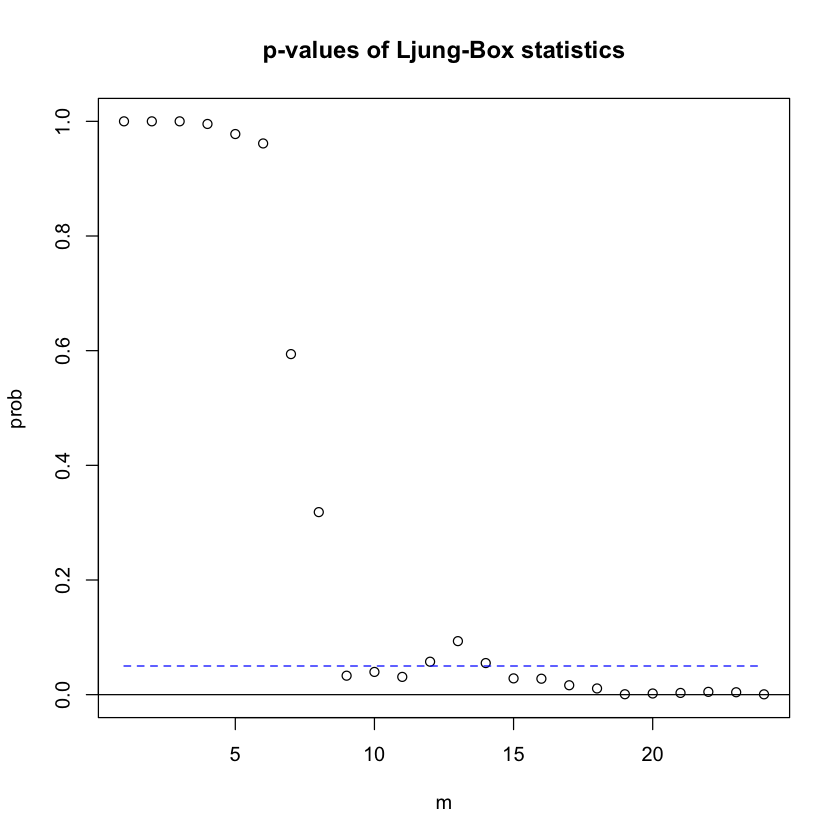

In [16]:
#Separemos primero los residuales del modelo de regresi√≥n y apliquemos la funci√≥n de mq() para la revisi√≥n de la calidad del modelo.
#Indicamos los grados de libertad del modelo, que son 8.
resi=var_model_mts$residuals
mq(resi, adj=8)



Revisando los rezagos de los residuos y considerando que este es un modelo AR(2) podemos evidenciar que los dos primeros puntos se encuentran por encima del umbral de la linea azul, indicando que no estan correlacionados entre ellos.

#### **5.2 Aplicacion modelo ARDL**

In [17]:
#Validacion de si se puede usar ARDL
adf.test(diff(s1)%>%na.omit())
adf.test(diff(s2)%>%na.omit())
adf.test(diff(s3)%>%na.omit())
adf.test(diff(s4)%>%na.omit())


	Augmented Dickey-Fuller Test

data:  diff(s1) %>% na.omit()
Dickey-Fuller = -8.0814, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff(s2) %>% na.omit()
Dickey-Fuller = -9.2478, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff(s3) %>% na.omit()
Dickey-Fuller = -10.768, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  diff(s4) %>% na.omit()
Dickey-Fuller = -9.895, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


Validacion de si se puede usar ARDL: En este caso al aplicar diferenciacion a las series podemos evidenciar que son I1 por lo que podemos aplicar el modelo de ARDL.

In [18]:
# Selecci√≥n autom√°tica del modelo ARDL
train_ts <- zoo(train_prices)
auto_model <- auto_ardl(RYLD ~ TSLA + TM + GM, data = train_ts, max_order = 6)

In [19]:
#Revisemos el top 20 de los mejores modelos seg√∫n su critrio de informaci√≥n de Akaike
auto_model$top_orders

RYLD TSLA TM GM AIC      
1  3    1    1  3  -307.4130
2  3    1    2  3  -305.8611
3  3    2    1  3  -305.5586
4  3    1    1  4  -304.8608
5  4    1    1  3  -304.0696
6  3    2    2  3  -303.9719
7  4    1    1  4  -303.0162
8  4    1    2  3  -302.5227
9  4    2    1  3  -302.2173
10 3    2    3  3  -302.0901
11 3    2    2  4  -301.3247
12 3    3    3  3  -301.2631
13 4    2    2  3  -300.6353
14 4    2    2  4  -299.4420
15 4    2    3  3  -298.7485
16 5    5    1  5  -298.2758
17 4    3    3  3  -297.9065
18 5    5    1  4  -297.6391
19 5    4    1  5  -297.1265
20 4    3    3  4  -296.8666

In [20]:
#Procedemos a construir el modelo de regresi√≥n con la mejor combinaci√≥n.
mod1 <- ardl(RYLD ~ TSLA + TM + GM, data = train_ts, order = c(3,1,1,3))
summary(mod1)


Time series regression with "zoo" data:
Start = 2019-04-25, End = 2022-10-24

Call:
dynlm::dynlm(formula = full_formula, data = data, start = start, 
    end = end)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67649 -0.10110  0.00956  0.11214  0.73684 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.1488489  0.0915044   1.627 0.104165    
L(RYLD, 1)   0.8668074  0.0309039  28.049  < 2e-16 ***
L(RYLD, 2)   0.3373508  0.0390773   8.633  < 2e-16 ***
L(RYLD, 3)  -0.2217836  0.0306534  -7.235 1.02e-12 ***
TSLA         0.0062359  0.0008919   6.992 5.41e-12 ***
L(TSLA, 1)  -0.0066197  0.0008909  -7.430 2.59e-13 ***
TM           0.0274560  0.0034883   7.871 1.04e-14 ***
L(TM, 1)    -0.0262163  0.0035202  -7.447 2.29e-13 ***
GM           0.0944349  0.0074301  12.710  < 2e-16 ***
L(GM, 1)    -0.0781005  0.0104085  -7.504 1.53e-13 ***
L(GM, 2)    -0.0346547  0.0103583  -3.346 0.000856 ***
L(GM, 3)     0.0214165  0.0075761   2.827 0.004809 ** 


In [21]:
# Para la interpretaci√≥n, podemos imprimir los rezagos correspondientes de cada variable que explican la respuesta.
mod1$full_formula

RYLD ~ L(RYLD, 1) + L(RYLD, 2) + L(RYLD, 3) + TSLA + L(TSLA, 
    1) + TM + L(TM, 1) + GM + L(GM, 1) + L(GM, 2) + L(GM, 3)

#### **5.2.1. Bound test para la verificacion de relaciones a largo t√©rmino - ARDL**

In [22]:
#Guardamos el mejor modelo obtenido en la secci√≥n anterior
modelo <- auto_model$best_model
#Realizamos la prueba de hipotesis: Hipotesis nula: no cointegraci√≥n
bounds_f_test(modelo, case = 2) # el parametro "case" igual a 2 verifica si existe relaciones a largo t√©rmino, con la combinaci√≥n de (restricted constant o intercepto cte, no linear trend o sin tendencia determinista).


	Bounds F-test (Wald) for no cointegration

data:  d(RYLD) ~ L(RYLD, 1) + L(TSLA, 1) + L(TM, 1) + L(GM, 1) + d(L(RYLD,     1)) + d(L(RYLD, 2)) + d(TSLA) + d(TM) + d(GM) + d(L(GM, 1)) +     d(L(GM, 2))
F = 2.5919, p-value = 0.2228
alternative hypothesis: Possible cointegration
null values:
   k    T 
   3 1000 


Hipotesis nula es que no hay cointegracion y la alternativa es que haya cointegracion. Con el p-value de  0.2228, no rechazo la hipotesis nula. Por lo que no hay evidencia estadisticamente significativa de cointegracion a largo plazo entre las variables del modelo especificado.

#### **5.2.2 Mutiplicadores de largo y corto termino**

In [23]:
#Multiplicadores a corto plazo
multipliers(modelo, type = "sr")
#Son los coeficientes que representan el impacto inmediato o dentro de unos pocos per√≠odos (pero antes de alcanzar el equilibrio de largo plazo) 

Term        Estimate    Std. Error   t value   Pr(>|t|)    
1 (Intercept) 0.148848875 0.0915043640  1.626686 1.041655e-01
2 TSLA        0.006235931 0.0008919174  6.991602 5.408892e-12
3 TM          0.027456034 0.0034882965  7.870900 1.043152e-14
4 GM          0.094434868 0.0074301356 12.709710 4.508574e-34

**Comportamiento del √≠ndice RYLD en funci√≥n de los activos:**
Los p-value de TSLA, TM y GM son significativos, por lo que estos activos generan un efecto en el corto plazo sobre el indice RYLD. 

* Un cambio unitario en TSLA estaria generando un incremento de 0.006 en el indice RYLD.
* Un cambio unitario en TM estaria generando un incremento de 0.027 en el indice RYLD.
* Un cambio unitario en GM estaria generando un incremento de 0.094 en el indice RYLD.


In [24]:
#Multiplicadores a largo plazo
multipliers(modelo)

Term        Estimate    Std. Error  t value   Pr(>|t|)    
1 (Intercept)  8.44514390 4.021866309  2.099807 0.0360329457
2 TSLA        -0.02177608 0.005783516 -3.765197 0.0001775872
3 TM           0.07034011 0.037839392  1.858912 0.0633766642
4 GM           0.17566844 0.054624276  3.215941 0.0013481119

Analizando la respuesta a largo plazo, podemos evidenciar:
* TSLA tiene un efecto negativo y significativo a largo plazo sobre RYLD.
* GM tiene un efecto positivo y significativo.
* TM tiene un efecto positivo pero marginalmente significativo.

El modelo sugiere que los movimientos en TSLA y GM son los m√°s relevantes para explicar cambios a largo plazo en RYLD.

### **7. Realiza un an√°lisis de impulso-respuesta sobre el modelo vectorial.**

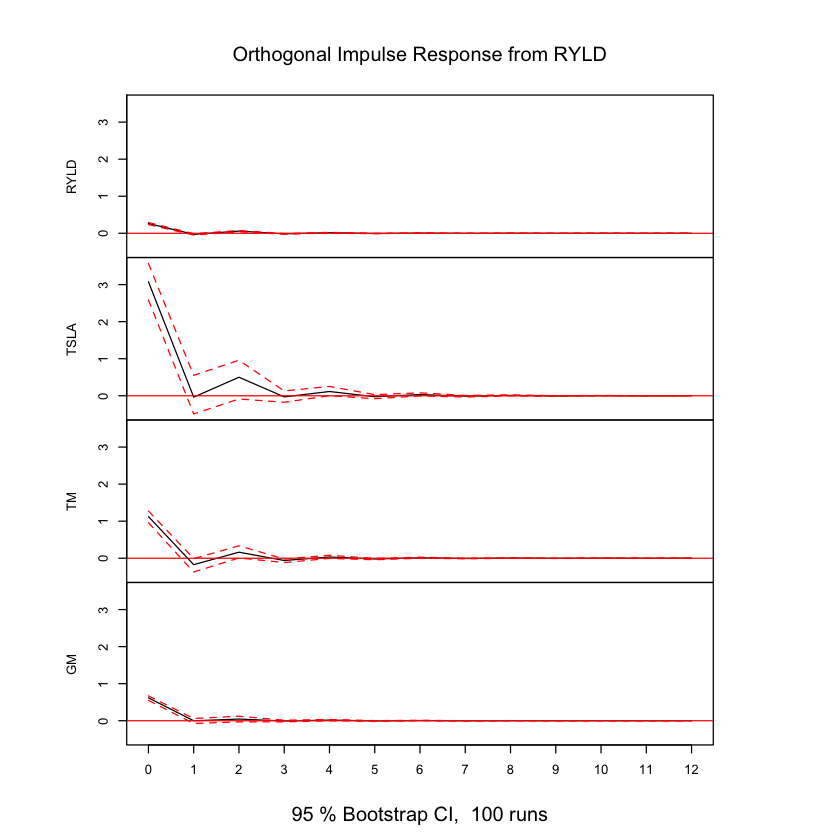

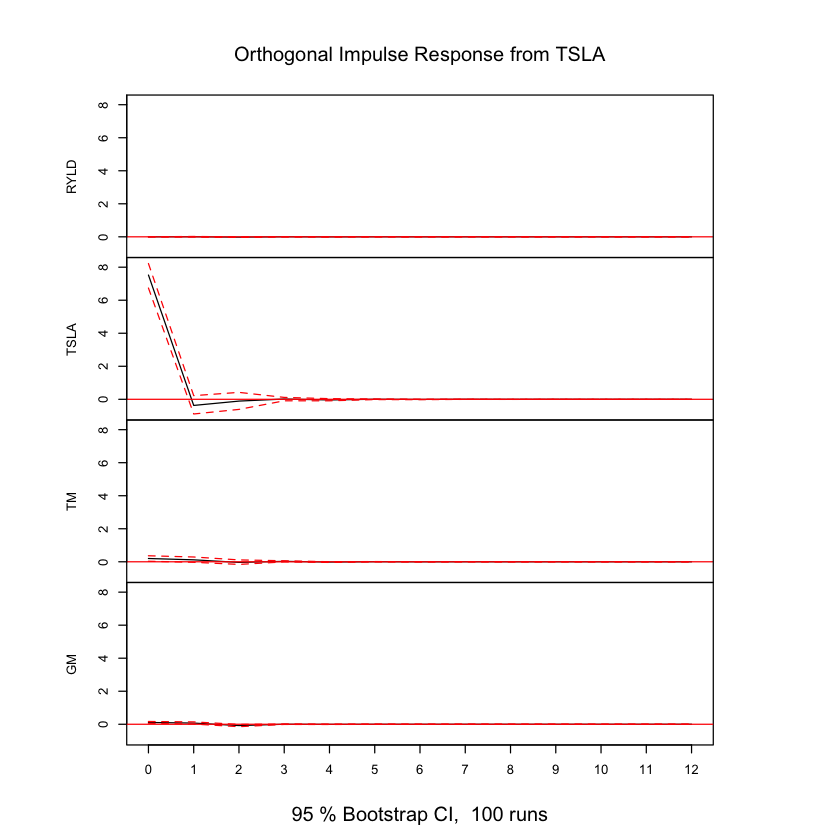

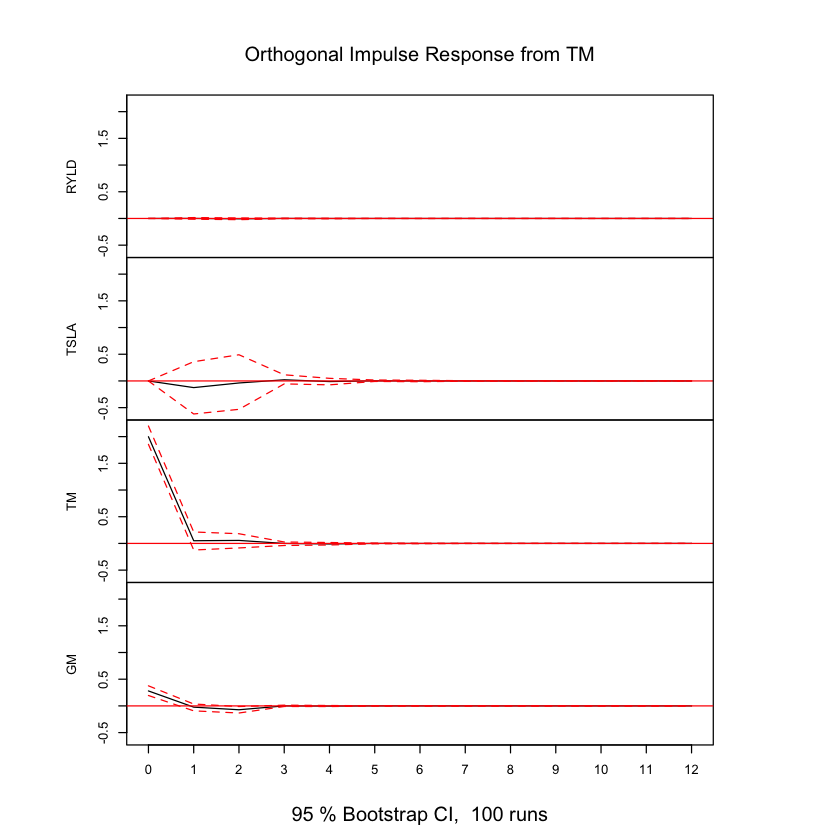

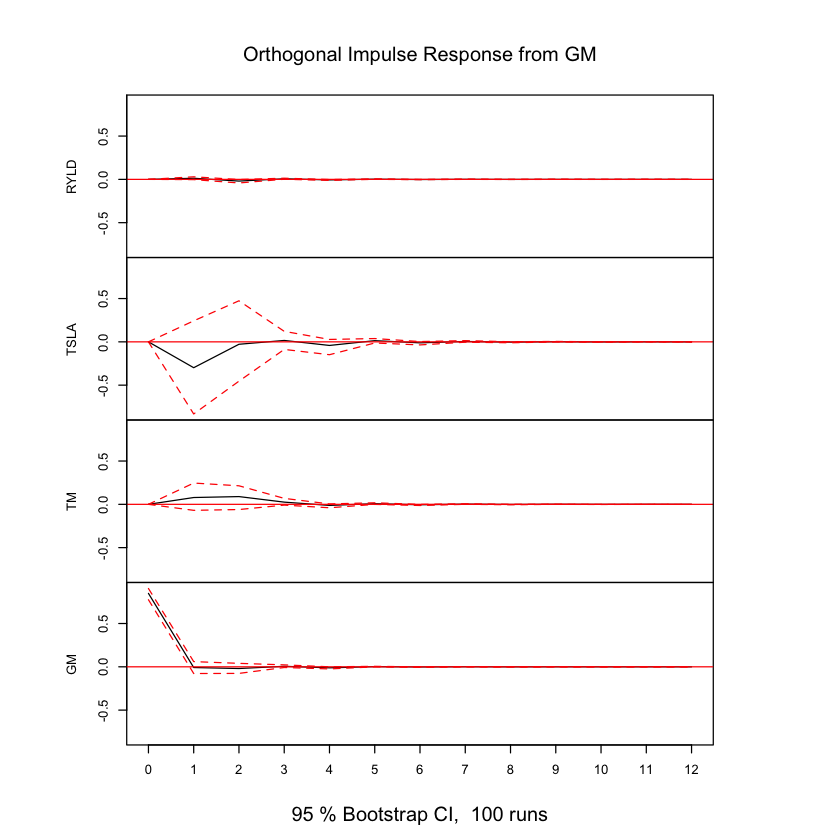

In [25]:
# La funci√≥n de impulso respuesta se lleva a cabo mediante la librer√≠a de vars. La funci√≥n es la irf(). Apliquemos la funci√≥n al primer modelo.
m1irf = irf(m0, n.ahead = 12, boot = TRUE)
plot(m1irf) 

De la funcion de impulso respuesta (irf) Podemos evidenciar que un impuso a la variable RYLD genera que esta caiga en el primer periodo, en el segundo sbe nuevamente y luego se estabiliza directamente. El precio de TSLA cae y se recupera en el 5 periodo. Por otro lado el precio de TM igualmente cae y se recupera en el periodo 4. Para la variable GM, auqnue tambien cae, se recupera mas pronto, en el periodo tres.

Cuando aplicamos un cambio en TSLA podemos ver que afecta fuertemente su precio y no genera una afectacion significativa en las otras variables.

Cuando aplicamos un cambio en TM podemos ver que afecta fuertemente su precio y afecta en menor medida los precios de TSLA y GM. Los precios de RYLD no se ven afectados.

Cuando aplicamos un cambio en GM podemos ver que afecta fuertemente su precio y afecta en menor medida los precios de TM (que supen un poco) y TSLA (que cae). Los precios de RYLD tienne una peque√±a afectacion.






### **8.Empleando tus resultados, calcula las m√©tricas para la medici√≥n de asertividad de un pron√≥stico, al menos debes calcular dos m√©tricos de error de pron√≥stico, ejemplo: MAPE, RMSE, MAE, entre otros.**

In [26]:
diff_test <- diff(test_prices)[-1, ]  # igual que hiciste con el train
# N√∫mero de pasos a predecir = longitud del conjunto de prueba
h <- nrow(diff_test)

# Predicci√≥n con el modelo VAR
forecast_var <- predict(m0, n.ahead = h)

# Extraer las predicciones para cada variable y combinarlas
pred_matrix <- sapply(forecast_var$fcst, function(x) x[, "fcst"])
pred_df <- as.data.frame(pred_matrix)
colnames(pred_df) <- colnames(diff_test)  # para alinear

# Convertir ambas a data.frame num√©rico
pred_df <- as.data.frame(lapply(pred_df, as.numeric))
diff_test <- as.data.frame(lapply(diff_test, as.numeric))

# Calcular RMSE por cada serie
rmse <- sqrt(colMeans((pred_df - diff_test)^2))

# Calcular MAE por cada serie
mae <- colMeans(abs(pred_df - diff_test))

print("RMSE modelo VAR:")
print(rmse)

print("MAE modelo VAR:")
print(mae)



[1] "RMSE modelo VAR:"
     RYLD      TSLA        TM        GM 
0.1320597 7.4167455 1.8893860 0.8188753 
[1] "MAE modelo VAR:"
     RYLD      TSLA        TM        GM 
0.1001395 5.6215463 1.4480250 0.6387399 


In [27]:
# ARDL RMSE - MAE

pred <- mod1$fitted.values

# Valores predichos y reales
pred_vec <- coredata(pred)
real_vec <- coredata(train_prices$RYLD[index(pred)])

# RMSE
rmse <- sqrt(mean((pred_vec - real_vec)^2, na.rm = TRUE))

# MAE
mae <- mean(abs(pred_vec - real_vec), na.rm = TRUE)

print(paste("RMSE modelo ARDL:", rmse))
print(paste("MAE modelo ARDL:", mae))


[1] "RMSE modelo ARDL: 0.200341050952005"
[1] "MAE modelo ARDL: 0.141832546232689"


# **Paso 2. Comparaci√≥n de los modelos y selecci√≥n del mejor**


### **1 Compara y sustenta qu√© modelo present√≥ un mejor desempe√±o de acuerdo a los criterios de selecci√≥n pertinentes.**

Conclusi√≥n
Tras comparar el desempe√±o de los modelos VAR y ARDL en la predicci√≥n de la variable dependiente RYLD, se concluye lo siguiente:

El modelo VAR obtiene mejores m√©tricas de error (menores valores de RMSE y MAE) para RYLD, lo cual indica una mayor precisi√≥n predictiva respecto al modelo ARDL.

Por lo tanto, el modelo VAR es el m√°s adecuado para este conjunto de datos y objetivo de pron√≥stico.

Comparaci√≥n de desempe√±o de modelos (Variable RYLD)

| Modelo   | RMSE     | MAE     |
|----------|----------|---------|
| **VAR**  | 0.1321   | 0.1001  |
| **ARDL** | 0.2003   | 0.1418  |

### **2. Genera un pron√≥stico de 10 d√≠as hacia adelante y una visualizaci√≥n del mismo.**



In [28]:
forecast_var <- predict(m0, n.ahead = 10)
#Como diferenciamos, recuperamos el nivel.
nhor=10 #pasos en el pron√≥stico.
nr_lev <- nrow(train_prices)
mr_lev= as.matrix(train_prices)
str(mr_lev)
m.varf_lev_ft <- rbind(mr_lev, matrix(NA, nhor, ncol(mr_lev)))
m.ft_df <- do.call(cbind,lapply(forecast_var$fcst, 
                                function(x) x[,"fcst"]))

                                

 num [1:886, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:886] "2019-04-22" "2019-04-23" "2019-04-24" "2019-04-25" ...
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


In [29]:
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}

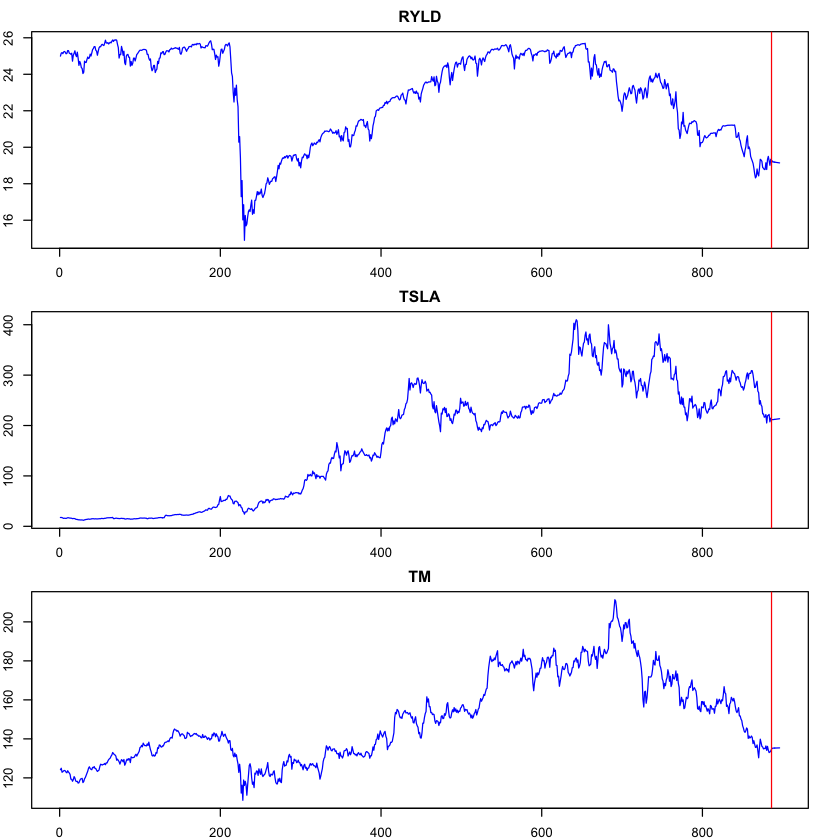

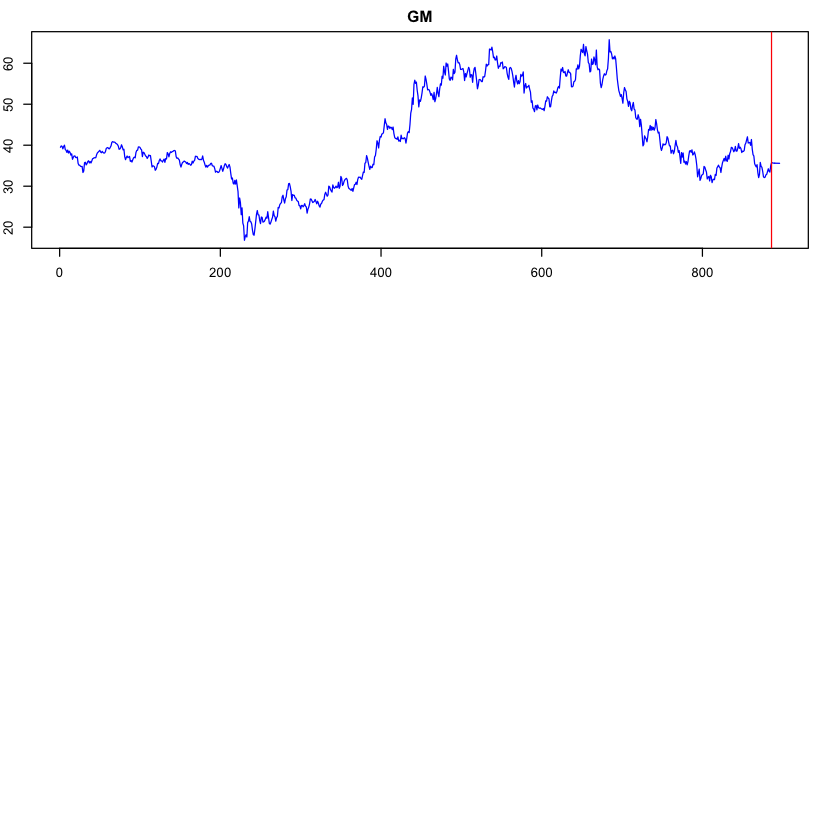

In [30]:
str.main=c("RYLD", "TSLA", "TM", "GM")
par(mfrow=c(3,1), mar=c(2,2,2,2))

for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="red")
}